In [1]:
import os
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import math
import pennylane as qml
import tqml
import torch
import gc
#from transformers import GPTNeoForCausalLM, GPT2Tokenizer
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics.text import Perplexity
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sklearn.metrics as metrics
from transformer_lens import HookedTransformer
from datasets import load_dataset

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module
optax not installed, `optimizer` from jax backend cannot work


In [3]:
RANDOM_SEED = 5678
torch.manual_seed(seed=RANDOM_SEED)
torch.cuda.manual_seed(seed=RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Tokenizer

In [5]:
reference_gpt2 = HookedTransformer.from_pretrained("gpt2-small", fold_ln=False, center_unembed=False, center_writing_weights=False)
gpt2_tokenizer = reference_gpt2.tokenizer

Loaded pretrained model gpt2-small into HookedTransformer


In [6]:
reference_gpt2.state_dict()['blocks.0.attn.W_O'].shape

torch.Size([12, 64, 768])

In [7]:
reference_text = ["Jingle bells, jingle bells, jingle all the way", "Today I was walking home, when suddenly"]
text_tokens = reference_gpt2.to_tokens(reference_text)
text_tokens

tensor([[50256,    41, 17697, 30987,    11,   474, 17697, 30987,    11,   474,
         17697,   477,   262,   835],
        [50256,  8888,   314,   373,  6155,  1363,    11,   618,  6451, 50256,
         50256, 50256, 50256, 50256]], device='cuda:0')

In [8]:
gpt2_tokenizer.decode(text_tokens[1])

'<|endoftext|>Today I was walking home, when suddenly<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [9]:
gpt2_tokenizer(" ")

{'input_ids': [220], 'attention_mask': [1]}

# Config

In [10]:
@dataclass
class Config:
    #classical params
    d_model: int = 768 #embedding size
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257
    init_range: float = 0.02
    n_ctx: int = 1024 #context length
    n_heads: int = 12 #number of attention heads
    n_layers: int = 12 #number of transformer blocks
    dropout: float = 0.1
    tying = False
    #quantum params
    query_depth: int = 2
    key_depth: int = 2
    value_depth: int = 2
    q_device: str = "lightning.qubit"
    speedy: bool = True
    n_qubits: int = 8

qgpt_cfg = Config()

# Embedding, MLP, Unembedding

In [11]:
class Embed(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.cfg = cfg
        self.wte = nn.Parameter(torch.empty((cfg.d_vocab, cfg.d_model)))
        self.wpe = nn.Parameter(torch.empty((cfg.n_ctx, cfg.d_model)))

        nn.init.normal_(self.wte, std=self.cfg.init_range)
        nn.init.normal_(self.wpe, std=self.cfg.init_range)

    def forward(self, tokens):

        tok_emb = self.wte[tokens]
        pos_emb = self.wpe[torch.arange(tokens.shape[1])]
        embeddings = tok_emb + pos_emb
        return embeddings

In [12]:
class MLP(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.w_in = nn.Linear(cfg.d_model, 4 * cfg.d_model)
        self.gelu = nn.GELU()
        self.w_out = nn.Linear(4 * cfg.d_model, cfg.d_model)
        self.dropout = nn.Dropout(cfg.dropout)

    def forward(self, x):
        x = self.w_in(x)
        x = self.gelu(x)
        x = self.w_out(x)
        x = self.dropout(x)
        return x

In [13]:
class Unembed(nn.Module):

    def __init__(self, cfg, tying=None): #tying should be the W_E matrix
        super().__init__()

        self.unembed = nn.Linear(cfg.d_model, cfg.d_vocab)
        if tying: self.unembed.weight = tying

    def forward(self, x):

        return self.unembed(x)


# Attention and transformer block

In [14]:
import tqml.tqnet.speedy_layers


class QAttention(torch.nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.cfg = cfg
        self.n_qubits = cfg.n_qubits
        self.qkv_depth = (cfg.query_depth, cfg.key_depth, cfg.value_depth)
        self.device = cfg.q_device
        self.speedy = cfg.speedy

        if self.cfg.d_model % self.n_qubits != 0:
            raise ValueError(f"in_features must be divisible by n_qubits, but got in_features={self.d_model} and n_qubits={self.n_qubits}")
        self.n_parallel = self.cfg.d_model // self.n_qubits #number of quantum heads

        # init device
        self.dev = qml.device(self.device, shots=None, wires=self.n_qubits)

        # decide if we use tqml or pennylane
        if self.speedy:
            self.speedy_query = tqml.tqnet.speedy_layers.SpeedyPQN(cfg.d_model, cfg.n_qubits, self.qkv_depth[0])
            self.speedy_key = tqml.tqnet.speedy_layers.SpeedyPQN(cfg.d_model, cfg.n_qubits, self.qkv_depth[1])
            self.speedy_value = tqml.tqnet.speedy_layers.SpeedyPQN(cfg.d_model, cfg.n_qubits, self.qkv_depth[2])
        else:
            self.query_weights = nn.Parameter(torch.empty(self.n_parallel, self.qkv_depth[0], self.n_qubits))
            self.key_weights = nn.Parameter(torch.empty(self.n_parallel, self.qkv_depth[1], self.n_qubits))
            self.value_weights = nn.Parameter(torch.empty(self.n_parallel, self.qkv_depth[2], self.n_qubits))
            self.reset_weights()
            self.query_node = qml.QNode(self.queryCircuit, self.dev, interface="torch", diff_method="best")
            self.key_node = qml.QNode(self.keyCircuit, self.dev, interface="torch", diff_method="best")
            self.value_node = qml.QNode(self.valueCircuit, self.dev, interface="torch", diff_method="best")
        
        #output projection is kept classical
        #self.W_O = nn.Linear(self.cfg.d_model, self.cfg.d_model)
        

    def queryCircuit(self, inputs, weights, depth):

        #quantum embedding
        qml.AngleEmbedding(inputs, range(self.n_qubits))

        #VQC
        for j in range(depth):
            for i in range(self.n_qubits):
                qml.RY(weights[j, i], wires=[i])

            for i in range(self.n_qubits):
                qml.CNOT(wires=[i % self.n_qubits, (i + 1) % self.n_qubits])

        return [qml.expval(qml.PauliZ(wires=[i])) for i in range(self.n_qubits)]

    def keyCircuit(self, inputs, weights, depth):
        return self.queryCircuit(inputs, weights, depth)

    def valueCircuit(self, inputs, weights, depth):
        return self.queryCircuit(inputs, weights, depth)

    def forward_with_pennylane(self, x):
        
        #x = (B, seq_len, emb_len)
        B, T, C = x.shape #save the batch size and sequence length for unflattening
        #flatten all batches into one sequence x = (B*seq_len, emb_len) for q_node
        x = torch.flatten(x, start_dim=0, end_dim=1)

        splitted = torch.split(x, self.n_qubits, dim=-1) #split x into n_parallel chunks each (B*seq_len, n_qubits)
        q, k, v = [], [], []
        for i in range(self.n_parallel):

            q_head = self.query_node(splitted[i], self.query_weights[i], self.qkv_depth[0])
            q_head = torch.stack(q_head, dim=-1) # q = (B*seq_len, n_qubit)
            q_head = torch.unflatten(q_head, 0, (B, T)) #q = (B, seq_len, n_qubit)
            q.append(q_head)

            k_head = self.query_node(splitted[i], self.query_weights[i], self.qkv_depth[0])
            k_head = torch.stack(k_head, dim=-1) # q = (B*seq_len, n_qubit)
            k_head = torch.unflatten(k_head, 0, (B, T)) #q = (B, seq_len, n_qubit)
            k.append(k_head)

            v_head = self.query_node(splitted[i], self.query_weights[i], self.qkv_depth[0])
            v_head = torch.stack(v_head, dim=-1) # q = (B*seq_len, n_qubit)
            v_head = torch.unflatten(v_head, 0, (B, T)) #q = (B, seq_len, n_qubit)
            v.append(v_head)
        
        
        q = torch.stack(q, dim=1)
        k = torch.stack(k, dim=1)
        v = torch.stack(v, dim=1)
        # q,k,v = (B, n_parallel, T, n_qubit)

        att = torch.nn.functional.scaled_dot_product_attention(q, k, v, is_causal=True) #(B, n_parallel, T, n_qubit)
        att = att.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        return att

    def forward_with_tqml(self, x):
        
        B, T, C = x.shape
        x = torch.flatten(x, start_dim=0, end_dim=1)
        
        q = self.speedy_query(x)
        q = torch.unflatten(q, 0, (B, T)) #q = (B, seq_len, n_qubit)
        q = torch.unsqueeze(q, 1)

        k = self.speedy_query(x)
        k = torch.unflatten(k, 0, (B, T))
        k = torch.unsqueeze(k, 1)

        v = self.speedy_query(x)
        v = torch.unflatten(v, 0, (B, T))
        v = torch.unsqueeze(v, 1)

        att = torch.nn.functional.scaled_dot_product_attention(q, k, v, is_causal=True) #(B, 1, T, C)
        att = torch.squeeze(att)
        return att


    def forward(self, x):
            
        if self.speedy:
            return self.forward_with_tqml(x)
        else:
            return self.forward_with_pennylane(x)


    def extra_repr(self):
        pass

    def reset_weights(self):

        nn.init.uniform_(self.query_weights, a=0, b=2 * torch.pi)
        nn.init.uniform_(self.key_weights, a=0, b=2 * torch.pi)
        nn.init.uniform_(self.value_weights, a=0, b=2 * torch.pi)

    def draw_circuit(self):
        sample_input = torch.randn((self.cfg.d_model,))

        query_drawer = qml.draw(self.query_node)
        query_diagram = query_drawer(sample_input, self.query_weights, self.qkv_depth[0])

        key_drawer = qml.draw(self.key_node)
        key_diagram = key_drawer(sample_input, self.key_weights, self.qkv_depth[1])

        value_drawer = qml.draw(self.value_node)
        value_diagram = value_drawer(sample_input, self.value_weights, self.qkv_depth[2])


        print("Query circuit:")
        print(query_diagram)
        print("Key circuit:")
        print(key_diagram)
        print("Value circuit:")
        print(value_diagram)


    def draw_circuit_mpl(self):
        # Generate a sample input and weights for visualization
        sample_input = torch.randn((self.n_qubits,))

        # Use qml.draw_mpl to plot the circuit
        qml.draw_mpl(self.query_node)(sample_input, self.weights[0])
        plt.title("Quantum Circuit")
        plt.show()

In [15]:
class TransformerBlock(torch.nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.cfg = cfg
        self.ln1 = nn.LayerNorm(cfg.d_model, eps=cfg.layer_norm_eps)
        self.ln2 = nn.LayerNorm(cfg.d_model, eps=cfg.layer_norm_eps)
        self.attn = QAttention(cfg)
        self.mlp = MLP(cfg)

    def forward(self, x):

        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

# Utils

In [16]:
def freeze_and_load(model, reference_model, n_unfreeze=0): #load mlp and ln weights and freeze them except last n blocks

    with torch.no_grad():

      #wte and wpe matrices
      model.embed.wte.copy_(reference_model.state_dict()['embed.W_E'])
      model.embed.wpe.copy_(reference_model.state_dict()['pos_embed.W_pos'])
      model.embed.wte.requires_grad_(False)
      model.embed.wpe.requires_grad_(False)

      #unembedding matrix
      model.unembed.unembed.weight.copy_(reference_model.state_dict()['unembed.W_U'].T) #for some strange reason pretrained W_U is transposed
      #print(model.unembed.unembed.bias.shape, reference_model.state_dict()['unembed.b_U'].shape)
      model.unembed.unembed.bias.copy_(reference_model.state_dict()['unembed.b_U'])
      model.unembed.unembed.requires_grad_(False)

      #final LayerNorm
      model.ln_final.weight.copy_(reference_model.state_dict()['ln_final.w'])
      model.ln_final.bias.copy_(reference_model.state_dict()['ln_final.b'])
      model.ln_final.requires_grad_(False)

      for (n, block) in enumerate(model.blocks):

        #LayerNorms
        block.ln1.weight.copy_(reference_model.state_dict()['blocks.'+str(n)+'.ln1.w'])
        block.ln1.bias.copy_(reference_model.state_dict()['blocks.'+str(n)+'.ln1.b'])
        block.ln2.weight.copy_(reference_model.state_dict()['blocks.'+str(n)+'.ln2.w'])
        block.ln2.bias.copy_(reference_model.state_dict()['blocks.'+str(n)+'.ln2.b'])
        #MLP (the pretrained weights are transposed)
        block.mlp.w_in.weight.copy_(reference_model.state_dict()['blocks.'+str(n)+'.mlp.W_in'].T)
        block.mlp.w_in.bias.copy_(reference_model.state_dict()['blocks.'+str(n)+'.mlp.b_in'])
        block.mlp.w_out.weight.copy_(reference_model.state_dict()['blocks.'+str(n)+'.mlp.W_out'].T)
        block.mlp.w_out.bias.copy_(reference_model.state_dict()['blocks.'+str(n)+'.mlp.b_out'])
        #freeze weights
        if n in range(model.cfg.n_layers-n_unfreeze):
          #print("weights in block "+str(n)+" frozen")
          block.ln1.requires_grad_(False)
          block.ln2.requires_grad_(False)
          block.mlp.w_in.requires_grad_(False)
          block.mlp.w_out.requires_grad_(False)


In [17]:
def save_model(model, optimizer, epoch_loss, epoch, filename):
  torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_log': epoch_loss,
        'epoch': epoch
        },
        filename
  )

# Full Transformer

In [18]:
class QGPT(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = nn.LayerNorm(cfg.d_model, eps=cfg.layer_norm_eps)
        self.unembed = Unembed(cfg)

    def forward(self, tokens):

        residual = self.embed(tokens)
        for block in self.blocks:
            residual = block(residual)
        logits = self.unembed(self.ln_final(residual))
        return logits

In [19]:
qgpt = QGPT(qgpt_cfg)

In [20]:
params = sum(p.numel() for p in qgpt.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {params}')

Number of trainable parameters: 134904913


In [21]:
freeze_and_load(qgpt, reference_gpt2)

In [22]:
params = sum(p.numel() for p in qgpt.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {params}')

Number of trainable parameters: 165888


In [23]:
#qgpt.half()
qgpt.to(device)

QGPT(
  (embed): Embed()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): QAttention(
        (speedy_query): SpeedyPQN(in_features=768, out_features=768, depth=2, n_qubits=8, embedding_layers=96,measurement_mode=None, rotation=Z, entangling=strong, measure=Y, hw_efficient=False)
        (speedy_key): SpeedyPQN(in_features=768, out_features=768, depth=2, n_qubits=8, embedding_layers=96,measurement_mode=None, rotation=Z, entangling=strong, measure=Y, hw_efficient=False)
        (speedy_value): SpeedyPQN(in_features=768, out_features=768, depth=2, n_qubits=8, embedding_layers=96,measurement_mode=None, rotation=Z, entangling=strong, measure=Y, hw_efficient=False)
      )
      (mlp): MLP(
        (w_in): Linear(in_features=768, out_features=3072, bias=True)
        (gelu): GELU(approximate='none')
        (w_out): Linear(in_features=

# Data

In [24]:
the_pile = load_dataset("NeelNanda/pile-10k", split="train").remove_columns("meta")
#wiki = load_dataset("NeelNanda/wiki-10k", split="train")
lambada = load_dataset("EleutherAI/lambada_openai")
openwebtext = load_dataset("Elriggs/openwebtext-100k")

In [25]:
len(openwebtext['train']['text'][2])

6021

In [26]:
class TextDataset(Dataset):
    def __init__(self, text_string, tokenizer, n_ctx):

      tokens = tokenizer(text_string)['input_ids']
      self.tokens = torch.tensor(tokens)
      self.X = torch.stack(torch.split(self.tokens, n_ctx)[:-1])
      self.y = torch.stack(torch.split(self.tokens.roll(-1), n_ctx)[:-1])

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]


In [27]:
pileDS = TextDataset(the_pile[0]['text'], gpt2_tokenizer, 64)
pileDL = DataLoader(pileDS, shuffle=True, pin_memory=True, batch_size=3)

Token indices sequence length is longer than the specified maximum sequence length for this model (3180 > 1024). Running this sequence through the model will result in indexing errors


In [28]:
lambadaDS = TextDataset('.'.join(lambada['test']['text'])[:10000], gpt2_tokenizer, 128)
lambadaDL = DataLoader(lambadaDS, shuffle=False)

In [29]:
openwebtextDS = TextDataset('.'.join(openwebtext['train']['text'])[:10000], gpt2_tokenizer, 64)
openwebtextDL = DataLoader(openwebtextDS, shuffle=True, pin_memory=True, batch_size=3)

# Pseudo model (approximate how much vram we need)

In [27]:
class PseudoModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.cfg = cfg
        self.emb = Embed(self.cfg)
        self.unemb = Unembed(self.cfg)

    def forward(self, x):

        x = self.emb(x)
        x = self.unemb(x)
        return x
        

In [28]:
pseudo_model = PseudoModel(qgpt_cfg)

In [29]:
params = sum(p.numel() for p in pseudo_model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {params}')

Number of trainable parameters: 78031441


In [30]:
pseudo_model.to(device)

PseudoModel(
  (emb): Embed()
  (unemb): Unembed(
    (unembed): Linear(in_features=768, out_features=50257, bias=True)
  )
)

In [31]:
pseudo_model(text_tokens).shape

torch.Size([2, 14, 50257])

# Train

In [30]:
@dataclass
class TrainingArgs:
    epochs: int = 30
    max_steps_per_epoch: int = 100
    lr: int = 0.05
    weight_decay: int = 0.01
    betas: tuple = (0.9, 0.98)

qgpt_training_args = TrainingArgs()

In [ ]:
class TransformerTrainer:
    def __init__(self, args, model, train_loader, test_loader):
        super().__init__()
        self.model = model
        self.args = args
        self.optimizer = optim.AdamW(self.model.parameters(), lr=args.lr, betas=args.betas, weight_decay=args.weight_decay)
        self.step = 0
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.metric = Perplexity(ignore_index=-1)


    def training_step(self, batch):

        #forward pass
        tokens, targets = batch
        tokens = tokens.to(device)
        targets = targets.to(device)
        logits = self.model(tokens)

        #backward pass
        self.optimizer.zero_grad()
        loss = nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        loss.backward()
        self.optimizer.step()
        self.step += 1

        
        tokens.detach().cpu()
        targets.detach().cpu()
        
        del tokens, targets, logits, batch
        gc.collect()
        with torch.no_grad():
            torch.cuda.empty_cache()
        gc.collect()
        

        return loss


    def test(self):

        self.model.eval()
        for batch in self.test_loader:
            
            tokens, targets = batch
            tokens.to(device)
            targets.to(device)
            
            logits = self.model(tokens)
            self.metric.update(logits.transpose(0, 1), targets.view(-1, 1))

            del tokens, targets, logits, batch
            gc.collect()
            with torch.no_grad():
                torch.cuda.empty_cache()
            gc.collect()
            
        return self.metric.compute()


    def train(self):

        accuracy = np.nan
        log_loss = []

        progress_bar = tqdm(total = self.args.max_steps_per_epoch * self.args.epochs)

        for epoch in range(self.args.epochs):
            batch_loss = 0
            for i, batch in enumerate(self.train_loader):

                self.model.train()
                loss = self.training_step(batch)
                batch_loss+=loss.detach().cpu().numpy()
                
                progress_bar.update()
                progress_bar.set_description(f"Epoch {epoch+1}, loss: {loss:.3f}")
                print(f"Epoch {epoch+1}, loss: {loss:.3f}")

                #cleanup
                
                del loss
                gc.collect()
                with torch.no_grad():
                    torch.cuda.empty_cache()
                gc.collect()

                
            batch_loss /= len(self.train_loader)
            log_loss.append(batch_loss)
            #print(f"PPL: {self.test()}")

            save_model(self.model, self.optimizer, log_loss, self.step, "qgpt100k.pth")

        return log_loss


In [32]:
qgpt_trainer = TransformerTrainer(qgpt_training_args, qgpt, openwebtextDL, lambadaDL)

In [ ]:
loss_log = qgpt_trainer.train()

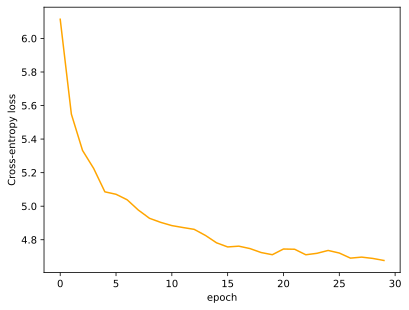

In [38]:
plt.plot(np.arange(qgpt_training_args.epochs), loss_log, color='orange')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")

plt.savefig('100k_loss.pdf', format='pdf')

# Inference

In [39]:
class Sampler:

    def __init__(self, cfg, model, tokenizer):

      self.cfg = cfg
      self.model = model
      self.tokenizer = tokenizer

    @torch.inference_mode()
    def generate(self, tokens, n_new_tokens, temperature=1.0, top_k=None):

        for _ in range(n_new_tokens):
            #crop sequence at context size if required
            cropped_tokens = tokens if tokens.size(1) <= self.cfg.n_ctx else tokens[:, -self.cfg.n_ctx:]
            #forward the model
            logits = self.model(cropped_tokens)
            #get the last logit and scale it by desired temperature
            logits = logits[:, -1, :] / temperature
            #apply top k
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            #softmax
            probs = nn.functional.softmax(logits, dim=-1)
            #sample nect tokens
            next_token = torch.multinomial(probs, num_samples=1)
            #add the sample token to the sequence
            tokens = torch.cat((tokens, next_token), dim=1)

        return tokens

    def sample(self, tokens, n_new_tokens, temperature=1, top_k=None):

        sentences = []
        token_sequences = self.generate(tokens, n_new_tokens, temperature, top_k)
        for sequence in token_sequences:
            sentence = self.tokenizer.decode(sequence)
            sentences.append(sentence)

        return sentences

In [40]:
qgpt_sampler = Sampler(qgpt_cfg, qgpt, gpt2_tokenizer)

In [41]:
qgpt_sampler.sample(text_tokens, 10, temperature=0.5)

['<|endoftext|>Jingle bells, jingle bells, jingle all the way through the Republican candidate for the security for the delegates',
 '<|endoftext|>Today I was walking home, when suddenly<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>"We have seen an investigation, but that the']

In [ ]:
gpt2_sampler = Sampler(qgpt_cfg, reference_gpt2, gpt2_tokenizer)

In [ ]:
qgpt_sampler.sample(text_tokens, 10, temperature=0.5)

# Testing

In [54]:
next(qgpt.parameters()).is_cuda

True

In [ ]:
#same as in the trainer class, better use it from there, this is a temporary solution
def test(model, test_loader):

    metric = Perplexity(ignore_index=-1).to(device)
    model.eval()
    for batch in test_loader:
        
        tokens, targets = batch
        tokens.to(device)
        targets.to(device)
        logits = model(tokens)
        metric.update(logits.transpose(0, 1), targets.view(-1, 1))

        del tokens, targets, logits, batch
        gc.collect()
        with torch.no_grad():
            torch.cuda.empty_cache()
        gc.collect()
        
    return metric.compute()

In [56]:
test(qgpt, lambadaDL)

tensor(422.0023, device='cuda:0', dtype=torch.float64)

In [53]:
qgpt.to('cpu')
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()
qgpt.to(device)

QGPT(
  (embed): Embed()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): QAttention(
        (speedy_query): SpeedyPQN(in_features=768, out_features=8, depth=2, n_qubits=8, embedding_layers=96,measurement_mode=None, rotation=Z, entangling=strong, measure=Y, hw_efficient=False)
        (speedy_key): SpeedyPQN(in_features=768, out_features=768, depth=2, n_qubits=8, embedding_layers=96,measurement_mode=None, rotation=Z, entangling=strong, measure=Y, hw_efficient=False)
        (speedy_value): SpeedyPQN(in_features=768, out_features=768, depth=2, n_qubits=8, embedding_layers=96,measurement_mode=None, rotation=Z, entangling=strong, measure=Y, hw_efficient=False)
      )
      (mlp): MLP(
        (w_in): Linear(in_features=768, out_features=3072, bias=True)
        (gelu): GELU(approximate='none')
        (w_out): Linear(in_features=30